<a href="https://colab.research.google.com/github/yanncoadou/MLtutorials/blob/main/Code_snipets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Collected bits and pieces</h1>

# Plot training and validation curves with uncertainty from CV

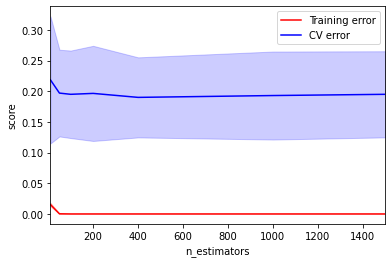

In [ ]:
from sklearn.model_selection import validation_curve

# Evaluate parameter range in CV
param_range = [10,50,100,200,400,1000,1500] #range(1, 400)
param_name = "n_estimators"

train_scores, test_scores = validation_curve(
    RandomForestClassifier(), X, y, 
    param_name=param_name, 
    param_range=param_range, cv=3, n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot parameter VS estimated error
plt.xlabel(param_name)
plt.ylabel("score")
plt.xlim(min(param_range), max(param_range))
plt.plot(param_range, 1. - train_scores_mean, color="red", label="Training error")
plt.fill_between(param_range, 
                 1. - train_scores_mean + train_scores_std,
                 1. - train_scores_mean - train_scores_std,
                 alpha=0.2, color="red")
plt.plot(param_range, 1. - test_scores_mean, color="blue", label="CV error")
plt.fill_between(param_range, 
                 1. - test_scores_mean + test_scores_std,
                 1. - test_scores_mean - test_scores_std, 
                 alpha=0.2, color="blue")
plt.legend(loc="best")

# Learning curve
Compute the AUC by varying the number of training event. Testing set remains the same.

In [ ]:
#In principle could, use learning_curve in sklearn
#However: it does not handle weights, it does not allow to control testing dataset size
#from sklearn.model_selection import learning_curve
#train_sizes,train_scores,test_scores=learning_curve(
#     RandomForestClassifier(n_estimators=100),
#     X_train,y_train,
#     train_sizes=[0.01,0.05,0.1,0.2,0.5,0.75,1],                  
#     scoring='roc_auc',cv=5)


train_sizes=[0.01,0.05,0.1,0.2,0.5,0.75,1]
ntrains=[]
test_aucs=[]
train_aucs=[]

for train_size in train_sizes:
  ntrain=int(len(X_train)*train_size)
  print("training with ",ntrain," events")
  ntrains+=[ntrain]

  tf.random.set_seed(1234) # to have reproducible networks
  model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)), # 1st hidden layer
    #tf.keras.layers.Dense(128, activation='relu'), # 2nd hidden layer
    tf.keras.layers.Dense(1,activation="sigmoid") # output layer
    ])

  model.compile(loss="binary_crossentropy",
                optimizer="adam",
                #metrics=['accuracy', keras.metrics.AUC(name="auc")]) # if not using event weights
                weighted_metrics=['accuracy', keras.metrics.AUC(name="auc")])

  # train using the first ntrain event of the training dataset
  model.fit(X_train[:ntrain], y_train[:ntrain],
            epochs=100, verbose=0,
            #validation_split=0.2,   # to be used with train/test split
            validation_data=(X_val, y_val, weights_val),
            batch_size=1024,
            sample_weight=weights_train[:ntrain].values,
            callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])

  # score on test dataset (always the same)
  y_pred_model=model.predict(X_test).reshape(-1)
  auc_test_model = roc_auc_score(y_true=y_test, y_score=y_pred_model,sample_weight=weights_test)
  test_aucs+=[auc_test_model]

  # score on the train dataset 
  y_train_model=model.predict(X_train[:ntrain]).reshape(-1)
  auc_train_model = roc_auc_score(y_true=y_train[:ntrain], y_score=y_train_model,sample_weight=weights_train[:ntrain])
  train_aucs+=[auc_train_model]

dflearning=pd.DataFrame({"Ntraining":ntrains,
                         "test_auc":test_aucs,
                         "train_auc":train_aucs})
display(dflearning)

training with  3464  events
training with  17320  events
training with  34641  events
training with  69282  events
training with  173206  events
training with  259809  events
training with  346413  events


,Ntraining,test_auc,train_auc
0,3464,0.796731,0.826305
1,17320,0.818830,0.826795
2,34641,0.817989,0.824158
3,69282,0.810805,0.812909
4,173206,0.864533,0.866964
5,259809,0.865876,0.867231
6,346413,0.864138,0.864985


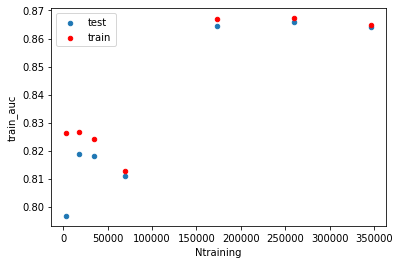

In [ ]:
ax=dflearning.plot.scatter("Ntraining","test_auc",label="test")
dflearning.plot.scatter("Ntraining","train_auc",label="train",color="r",ax=ax)

# Model conversion from XGBoost to ONNX (to be fixed)


In [ ]:
!pip install skl2onnx onnxmltools
from skl2onnx import convert_sklearn, update_registered_converter
from skl2onnx.common.data_types import FloatTensorType
from skl2onnx.common.shape_calculator import calculate_linear_classifier_output_shapes
from onnxmltools.convert.xgboost.operator_converters.XGBoost import convert_xgboost
#from onnxmltools.convert import convert_xgboost as convert_xgboost_booster

     |████████████████████████████████| 300 kB 7.2 MB/s 


In [ ]:
update_registered_converter(
    XGBClassifier, 'XGBoostXGBClassifier',
    calculate_linear_classifier_output_shapes, convert_xgboost,
    options={'nocl': [True, False], 'zipmap': [True, False, 'columns']})

In [ ]:
X_test.values

array([[-0.1362578 ,  0.86665251,  0.02508858, -0.05444248,  1.67018596,
        -1.39623384],
       [-0.07783699,  1.30600348, -0.49124578,  0.218963  ,  0.6723398 ,
        -0.71439262],
       [-0.37522089, -0.41543544, -0.09169988,  0.17476269,  1.41391879,
         1.30101818],
       ...,
       [-0.66775242,  1.00083118, -0.33291626, -0.90773209, -1.09861489,
         0.14798789],
       [-0.17578215,  0.50170971,  0.10804866, -0.90832872, -1.16239178,
        -1.52308289],
       [ 0.07002129,  0.10438409, -0.54049951, -0.55685426, -1.06912843,
         1.28893994]])

In [ ]:
initial_type = [('float_input', FloatTensorType([None, X_test.shape[1]]))]
onnx_xgb = convert_sklearn(xgb, initial_types=initial_type)[0]

RuntimeError: ignored

In [ ]:
import onnx
onnx.save(onnx_model,'onnx_model.onnx')
!ls -rtl

In [ ]:
!pip install onnxruntime
import onnxruntime as ort
sess = ort.InferenceSession('onnx_model.onnx', providers = ['CPUExecutionProvider'])

In [ ]:
input_name = sess.get_inputs()[0].name
output_names = [n.name for n in onnx_model.graph.output]
print(input_name)
print(output_names)

In [ ]:
pred_onnx = sess.run(output_names,{input_name: X_test.values.astype(np.float32)})[0]
print(pred_onnx[:5].reshape(-1))
print(y_pred_model[:5])

In [ ]:
try:
  np.testing.assert_allclose(
    y_pred_model, pred_onnx.reshape(-1),
    rtol=1e-3, atol=0
  )
  print("Predictions from original and ONNX models are identical")
except AssertionError:
  print("Error: predictions from original and ONNX models are different")
